In [1]:
#import packages
import pandas as pd
import geopandas as gpd
from shapely.geometry import shape, Point
import requests
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import urllib.request, json
import requests
import urllib.parse
import datetime
import pickle

import warnings
warnings.filterwarnings('ignore')

In [2]:
with open('../Outputs/serv_req_compound_score.pickle', 'rb') as f:
    compound_dict = pickle.load(f)

compound_dict

{'APPLIANCE': 0.0,
 'Abandoned Vehicle': -0.8070740074257988,
 'Derelict Vehicle': -0.8070740074257988,
 'Derelict Vehicles': -0.8070740074257988,
 'Advocate-Prop Refunds/Credits': 0.1531,
 'Air Quality': -0.47975298403886185,
 'Indoor Air Quality': -0.47975298403886185,
 'Animal Abuse': -0.86285,
 'Animal-Abuse': -0.86285,
 'Animal in a Park': -0.7293419713831478,
 'Asbestos': -0.5208125910509885,
 'Beach/Pool/Sauna Complaint': -0.19575233644859813,
 'Benefit Card Replacement': -0.27469767441860465,
 'Blocked Driveway': -0.5719,
 'Boilers': -0.627537529060113,
 'Borough Office': -0.05624012372144301,
 'Bridge Condition': -0.5267,
 'Bus Stop Shelter Complaint': -0.7441,
 'Bus Stop Shelter Placement': -0.7441,
 'Collection Truck Noise': -0.09766089463854599,
 'Noise': -0.09766089463854599,
 'Noise - Commercial': -0.09766089463854599,
 'Noise - Helicopter': -0.09766089463854599,
 'Noise - House of Worship': -0.09766089463854599,
 'Noise - Park': -0.09766089463854599,
 'Noise - Residentia

In [3]:
from shapely import wkt

nta_nyc = pd.read_csv('../Data/2020NTA.csv')
nta_nyc['geometry'] = nta_nyc['geometry'].apply(wkt.loads)
nta_nyc = gpd.GeoDataFrame(nta_nyc,geometry = 'geometry',crs = '4326')
nta_nyc.head()

,OBJECTID,BoroCode,BoroName,CountyFIPS,NTA2020,NTAName,NTAAbbrev,NTAType,CDTA2020,CDTAName,Shape__Area,Shape__Length,geometry
0,1,3,Brooklyn,47,BK0101,Greenpoint,Grnpt,0,BK01,BK01 Williamsburg-Greenpoint (CD 1 Equivalent),3.532179e+07,28914.131640,"POLYGON ((-73.93214 40.72817, -73.93238 40.728..."
1,2,3,Brooklyn,47,BK0102,Williamsburg,Wllmsbrg,0,BK01,BK01 Williamsburg-Greenpoint (CD 1 Equivalent),2.886214e+07,28158.316197,"POLYGON ((-73.96176 40.72524, -73.96154 40.725..."
2,3,3,Brooklyn,47,BK0103,South Williamsburg,SWllmsbrg,0,BK01,BK01 Williamsburg-Greenpoint (CD 1 Equivalent),1.520896e+07,18250.280262,"POLYGON ((-73.95024 40.70548, -73.94984 40.705..."
3,4,3,Brooklyn,47,BK0104,East Williamsburg,EWllmsbrg,0,BK01,BK01 Williamsburg-Greenpoint (CD 1 Equivalent),5.226628e+07,43184.732279,"POLYGON ((-73.92406 40.71412, -73.92404 40.714..."
4,5,3,Brooklyn,47,BK0201,Brooklyn Heights,BkHts,0,BK02,BK02 Downtown Brooklyn-Fort Greene (CD 2 Appro...,9.982387e+06,14312.482065,"POLYGON ((-73.99237 40.68970, -73.99436 40.690..."


In [4]:
url = 'https://data.cityofnewyork.us/resource/erm2-nwe9.json'

query = (url +'?'
        "$select= unique_key,agency_name,complaint_type,latitude,longitude,created_date"
        "&$where=created_date between '2019-01-01T00:00:00.000' and '2019-12-31T23:59:59.999'"
        "&$limit=5000000")
query = query.replace(" ", "%20")
response = urllib.request.urlopen(query)
data = json.loads(response.read())

df = pd.DataFrame(data)[['agency_name','complaint_type', 'latitude', 'longitude', 'created_date', 'unique_key']]
df = df[df['latitude'].notnull()]
df = df[df['longitude'].notnull()]

#apply the same replacement as we did in the original dictionary script
df['complaint_type'] = df['complaint_type'].str.replace('SCRIE','Senior Citizen Rent Increase') 
df['complaint_type'] = df['complaint_type'].str.replace('DRIE','Disability Rent Increase') 
df['complaint_type'] = df['complaint_type'].str.replace('RPIE','Real Property Income and Expense') 
df['complaint_type'] = df['complaint_type'].str.replace('DOF','Department of Finance')
df['complaint_type'] = df['complaint_type'].str.replace('DCA','Department of Consumer Affairs')
df['complaint_type'] = df['complaint_type'].str.replace('DOH','Department of Finance')
df['complaint_type'] = df['complaint_type'].str.replace('DEP','Department of Environmental Protection')
df['complaint_type'] = df['complaint_type'].str.replace('DPR','Department of Parks and Recreation')
df['complaint_type'] = df['complaint_type'].str.replace('DPR','Department of Parks and Recreation')
df['complaint_type'] = df['complaint_type'].str.replace('DPR','Department of Parks and Recreation')
df['complaint_type'] = df['complaint_type'].str.replace('HPD','Department of Housing Preservation and Development')

# Step 2: Assign complaints to neighborhoods
geometry = [Point(xy) for xy in zip(df.longitude.astype(float), df.latitude.astype(float))]
crs = {'init': 'epsg:4326'}
complaints = gpd.GeoDataFrame(df, crs=crs, geometry=geometry)
complaints = gpd.sjoin(complaints, nta_nyc, how='inner',predicate = 'within')
complaints['compound_score'] = complaints['complaint_type'].map(compound_dict)
complaints = complaints.dropna(subset = 'compound_score').reset_index(drop = True)

In [5]:
complaints.head(10)

,agency_name,complaint_type,latitude,longitude,created_date,unique_key,geometry,index_right,OBJECTID,BoroCode,...,CountyFIPS,NTA2020,NTAName,NTAAbbrev,NTAType,CDTA2020,CDTAName,Shape__Area,Shape__Length,compound_score
0,New York City Police Department,Noise - Commercial,40.58507695307629,-73.92773945669528,2019-12-31T23:59:11.000,45278137,POINT (-73.92774 40.58508),51,52,3,...,47,BK1503,Sheepshead Bay-Manhattan Beach-Gerritsen Beach,ShpshdBy,0,BK15,BK15 Sheepshead Bay-Gravesend (East) (CD 15 Ap...,6.337062e+07,91279.35975,-0.097661
1,New York City Police Department,Noise - Residential,40.58428604671687,-73.93156372953595,2019-12-31T22:57:34.000,45282290,POINT (-73.93156 40.58429),51,52,3,...,47,BK1503,Sheepshead Bay-Manhattan Beach-Gerritsen Beach,ShpshdBy,0,BK15,BK15 Sheepshead Bay-Gravesend (East) (CD 15 Ap...,6.337062e+07,91279.35975,-0.097661
2,New York City Police Department,Noise - Residential,40.591799180563235,-73.95506080572147,2019-12-31T22:25:25.000,45280268,POINT (-73.95506 40.59180),51,52,3,...,47,BK1503,Sheepshead Bay-Manhattan Beach-Gerritsen Beach,ShpshdBy,0,BK15,BK15 Sheepshead Bay-Gravesend (East) (CD 15 Ap...,6.337062e+07,91279.35975,-0.097661
3,New York City Police Department,Noise - Residential,40.59276471972267,-73.94146766063803,2019-12-31T21:36:10.000,45278037,POINT (-73.94147 40.59276),51,52,3,...,47,BK1503,Sheepshead Bay-Manhattan Beach-Gerritsen Beach,ShpshdBy,0,BK15,BK15 Sheepshead Bay-Gravesend (East) (CD 15 Ap...,6.337062e+07,91279.35975,-0.097661
4,New York City Police Department,Blocked Driveway,40.59455448927831,-73.94178295844772,2019-12-31T20:51:37.000,45280449,POINT (-73.94178 40.59455),51,52,3,...,47,BK1503,Sheepshead Bay-Manhattan Beach-Gerritsen Beach,ShpshdBy,0,BK15,BK15 Sheepshead Bay-Gravesend (East) (CD 15 Ap...,6.337062e+07,91279.35975,-0.571900
5,New York City Police Department,Illegal Fireworks,40.59119640792019,-73.92982476999704,2019-12-31T20:39:09.000,45281443,POINT (-73.92982 40.59120),51,52,3,...,47,BK1503,Sheepshead Bay-Manhattan Beach-Gerritsen Beach,ShpshdBy,0,BK15,BK15 Sheepshead Bay-Gravesend (East) (CD 15 Ap...,6.337062e+07,91279.35975,-0.659700
6,Department of Sanitation,Request Large Bulky Item Collection,40.59677757063344,-73.94703109956448,2019-12-31T20:02:00.000,45282470,POINT (-73.94703 40.59678),51,52,3,...,47,BK1503,Sheepshead Bay-Manhattan Beach-Gerritsen Beach,ShpshdBy,0,BK15,BK15 Sheepshead Bay-Gravesend (East) (CD 15 Ap...,6.337062e+07,91279.35975,-0.284222
7,New York City Police Department,Blocked Driveway,40.590884727676176,-73.94755785499609,2019-12-31T19:16:23.000,45280481,POINT (-73.94756 40.59088),51,52,3,...,47,BK1503,Sheepshead Bay-Manhattan Beach-Gerritsen Beach,ShpshdBy,0,BK15,BK15 Sheepshead Bay-Gravesend (East) (CD 15 Ap...,6.337062e+07,91279.35975,-0.571900
8,New York City Police Department,Illegal Parking,40.59083589355055,-73.94299598753597,2019-12-31T19:15:12.000,45282733,POINT (-73.94300 40.59084),51,52,3,...,47,BK1503,Sheepshead Bay-Manhattan Beach-Gerritsen Beach,ShpshdBy,0,BK15,BK15 Sheepshead Bay-Gravesend (East) (CD 15 Ap...,6.337062e+07,91279.35975,-0.627298
9,New York City Police Department,Blocked Driveway,40.593287630646785,-73.95026368613244,2019-12-31T18:23:23.000,45280466,POINT (-73.95026 40.59329),51,52,3,...,47,BK1503,Sheepshead Bay-Manhattan Beach-Gerritsen Beach,ShpshdBy,0,BK15,BK15 Sheepshead Bay-Gravesend (East) (CD 15 Ap...,6.337062e+07,91279.35975,-0.571900


In [6]:
len(complaints)

1957439

In [8]:
# Step 4: Aggregate complaints by neighborhood and complaint type
nta_complaint_score = complaints[['NTAName','complaint_type','compound_score','unique_key']].groupby(by = ['NTAName','complaint_type','compound_score']).nunique().reset_index()
nta_complaint_score['num'] = nta_complaint_score['unique_key']*nta_complaint_score['compound_score']
nta_complaint_score.head()

,NTAName,complaint_type,compound_score,unique_key,num
0,Allerton,APPLIANCE,0.000000,57,0.000000
1,Allerton,Abandoned Vehicle,-0.807074,35,-28.247590
2,Allerton,Air Quality,-0.479753,20,-9.595060
3,Allerton,Animal Abuse,-0.862850,28,-24.159800
4,Allerton,Animal in a Park,-0.729342,4,-2.917368


In [9]:
nta_comp_score_num = nta_complaint_score[['NTAName','num']].groupby(by = 'NTAName').sum()
nta_comp_score_num.head()

,num
NTAName,
Allerton,-2627.631194
Alley Pond Park,-44.143196
Annadale-Huguenot-Prince's Bay-Woodrow,-3718.471824
Arden Heights-Rossville,-2665.578486
Astoria (Central),-3739.305409


In [10]:
nta_comp_score_denom = complaints[['NTAName','unique_key']].groupby(by = 'NTAName').nunique().reset_index()
nta_comp_score_denom.head()

,NTAName,unique_key
0,Allerton,7422
1,Alley Pond Park,124
2,Annadale-Huguenot-Prince's Bay-Woodrow,9562
3,Arden Heights-Rossville,6630
4,Astoria (Central),11504


In [11]:
nta_comp_score_weighted_avg = pd.merge(nta_comp_score_num,nta_comp_score_denom,on = 'NTAName')
nta_comp_score_weighted_avg['weighted_avg'] = nta_comp_score_weighted_avg['num'] / nta_comp_score_weighted_avg['unique_key']
nta_comp_score_weighted_avg.head()

,NTAName,num,unique_key,weighted_avg
0,Allerton,-2627.631194,7422,-0.354033
1,Alley Pond Park,-44.143196,124,-0.355994
2,Annadale-Huguenot-Prince's Bay-Woodrow,-3718.471824,9562,-0.388880
3,Arden Heights-Rossville,-2665.578486,6630,-0.402048
4,Astoria (Central),-3739.305409,11504,-0.325044


In [12]:
nta_comp_score_weighted_avg = nta_comp_score_weighted_avg[['NTAName','weighted_avg']]

In [13]:
nta_score_geo = pd.merge(nta_nyc,nta_comp_score_weighted_avg, on = 'NTAName',how = 'left')
nta_score_geo.head()

,OBJECTID,BoroCode,BoroName,CountyFIPS,NTA2020,NTAName,NTAAbbrev,NTAType,CDTA2020,CDTAName,Shape__Area,Shape__Length,geometry,weighted_avg
0,1,3,Brooklyn,47,BK0101,Greenpoint,Grnpt,0,BK01,BK01 Williamsburg-Greenpoint (CD 1 Equivalent),3.532179e+07,28914.131640,"POLYGON ((-73.93214 40.72817, -73.93238 40.728...",-0.341971
1,2,3,Brooklyn,47,BK0102,Williamsburg,Wllmsbrg,0,BK01,BK01 Williamsburg-Greenpoint (CD 1 Equivalent),2.886214e+07,28158.316197,"POLYGON ((-73.96176 40.72524, -73.96154 40.725...",-0.295750
2,3,3,Brooklyn,47,BK0103,South Williamsburg,SWllmsbrg,0,BK01,BK01 Williamsburg-Greenpoint (CD 1 Equivalent),1.520896e+07,18250.280262,"POLYGON ((-73.95024 40.70548, -73.94984 40.705...",-0.376319
3,4,3,Brooklyn,47,BK0104,East Williamsburg,EWllmsbrg,0,BK01,BK01 Williamsburg-Greenpoint (CD 1 Equivalent),5.226628e+07,43184.732279,"POLYGON ((-73.92406 40.71412, -73.92404 40.714...",-0.340401
4,5,3,Brooklyn,47,BK0201,Brooklyn Heights,BkHts,0,BK02,BK02 Downtown Brooklyn-Fort Greene (CD 2 Appro...,9.982387e+06,14312.482065,"POLYGON ((-73.99237 40.68970, -73.99436 40.690...",-0.320416


<Axes: >

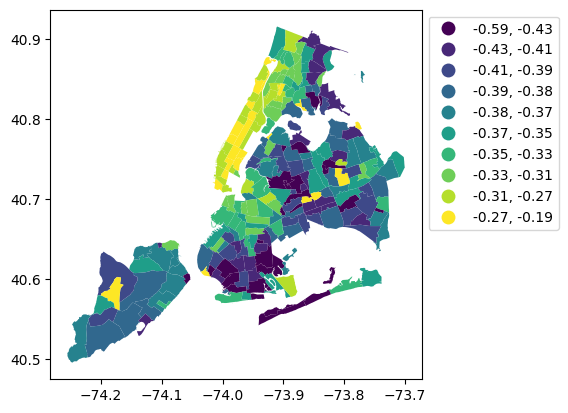

In [14]:
nta_score_geo.plot(column = 'weighted_avg', k=10, scheme='Quantiles',legend=True
             ,legend_kwds={'bbox_to_anchor': (1, 1),'loc': 'upper left'})

In [15]:
from sklearn import preprocessing
min_max_scaler = preprocessing.MinMaxScaler()
nta_score_geo['severity_norm'] = min_max_scaler.fit_transform(np.asarray(nta_score_geo['weighted_avg']).reshape(-1, 1))
nta_score_geo.head()

,OBJECTID,BoroCode,BoroName,CountyFIPS,NTA2020,NTAName,NTAAbbrev,NTAType,CDTA2020,CDTAName,Shape__Area,Shape__Length,geometry,weighted_avg,severity_norm
0,1,3,Brooklyn,47,BK0101,Greenpoint,Grnpt,0,BK01,BK01 Williamsburg-Greenpoint (CD 1 Equivalent),3.532179e+07,28914.131640,"POLYGON ((-73.93214 40.72817, -73.93238 40.728...",-0.341971,0.613614
1,2,3,Brooklyn,47,BK0102,Williamsburg,Wllmsbrg,0,BK01,BK01 Williamsburg-Greenpoint (CD 1 Equivalent),2.886214e+07,28158.316197,"POLYGON ((-73.96176 40.72524, -73.96154 40.725...",-0.295750,0.728616
2,3,3,Brooklyn,47,BK0103,South Williamsburg,SWllmsbrg,0,BK01,BK01 Williamsburg-Greenpoint (CD 1 Equivalent),1.520896e+07,18250.280262,"POLYGON ((-73.95024 40.70548, -73.94984 40.705...",-0.376319,0.528155
3,4,3,Brooklyn,47,BK0104,East Williamsburg,EWllmsbrg,0,BK01,BK01 Williamsburg-Greenpoint (CD 1 Equivalent),5.226628e+07,43184.732279,"POLYGON ((-73.92406 40.71412, -73.92404 40.714...",-0.340401,0.617522
4,5,3,Brooklyn,47,BK0201,Brooklyn Heights,BkHts,0,BK02,BK02 Downtown Brooklyn-Fort Greene (CD 2 Appro...,9.982387e+06,14312.482065,"POLYGON ((-73.99237 40.68970, -73.99436 40.690...",-0.320416,0.667245


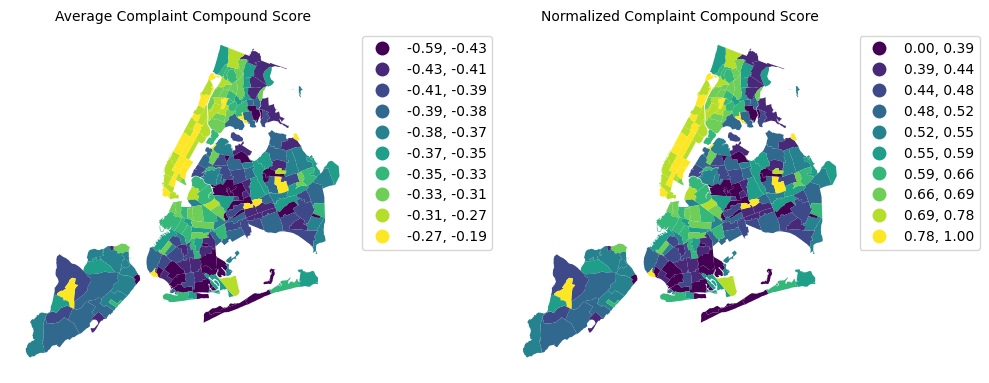

In [19]:
fig,ax = plt.subplots(1,2,figsize = (10,10))
nta_score_geo.plot(column = 'weighted_avg',ax = ax[0], k=10, scheme='Quantiles',legend=True
             ,legend_kwds={'bbox_to_anchor': (1, 1),'loc': 'upper left'})
nta_score_geo.plot(column = 'severity_norm',ax = ax[1], k=10, scheme='Quantiles',legend=True
             ,legend_kwds={'bbox_to_anchor': (1, 1),'loc': 'upper left'})
ax[0].set_title('Average Complaint Compound Score',fontsize = 10)
ax[0].axis('off')
ax[1].set_title('Normalized Complaint Compound Score',fontsize = 10)
ax[1].axis('off')
fig.tight_layout()
plt.savefig('../Outputs/compound_score_spatial_graphs.png', bbox_inches='tight')
plt.show()

In [17]:
nta_score_final = nta_score_geo[['NTAName','weighted_avg','severity_norm']]
nta_score_final = nta_score_final.rename(columns = {'weighted_avg':'avg_compound_score','severity_norm':'norm_compound_score'})
nta_score_final.head()

,NTAName,avg_compound_score,norm_compound_score
0,Greenpoint,-0.341971,0.613614
1,Williamsburg,-0.295750,0.728616
2,South Williamsburg,-0.376319,0.528155
3,East Williamsburg,-0.340401,0.617522
4,Brooklyn Heights,-0.320416,0.667245


In [18]:
nta_score_final.to_csv('../Data/nta_complaint_severity_2019.csv')